## Фреймворк PyTorch для разработки искусственных нейронных сетей
### Курсовая работа - Hand Gesture Recognition Database
#### Acquired by Leap Motion

![image](dataset-cover.png)  

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты.   
На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.  
Для распознавания жестов, вам надо будет скачать датасет  https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.  

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [2]:
import os
import time
import cv2 #Image handling library

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

from PIL import Image
from torch.autograd import Variable

import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Часть 1. Подготовка данных

In [5]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']

In [6]:
# IMG_SIZE = 64

# # paths for dataset
# data_path = "../input/leapgestrecog/leapGestRecog"

In [7]:
# Модуль glob находит все пути, совпадающие с заданным шаблоном в соответствии с правилами. 
# glob.glob(pathname) возвращение список (возможно, пустой) путей, соответствующих шаблону pathname.
import glob
images = glob.glob('D:/kaggle/leapGestRecog/**/**/*.png')

# extract label number from filename and reduce by 1 so that it ranges from 0 to 9 (instead of 1 to 10). Otherwise loss function will complain
labels = [int(os.path.basename(i).split('_')[2])-1 for i in images]

In [8]:
train_transformer = transforms.Compose([
                    transforms.Resize(64),              # resize the image to 64x64 
                    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
                    transforms.ToTensor()])             # transform it into a PyTorch Tensor

test_transformer =   transforms.Compose([
                    transforms.Resize(64),              # resize the image to 64x64 
                    transforms.ToTensor()]) 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.3, random_state=0)

In [10]:
class SIGNSDataset(Dataset):
    def __init__(self, filenames, labels, transform):      
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #return size of dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        #open image, apply transforms and return with label
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [12]:
CATEGORIES

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

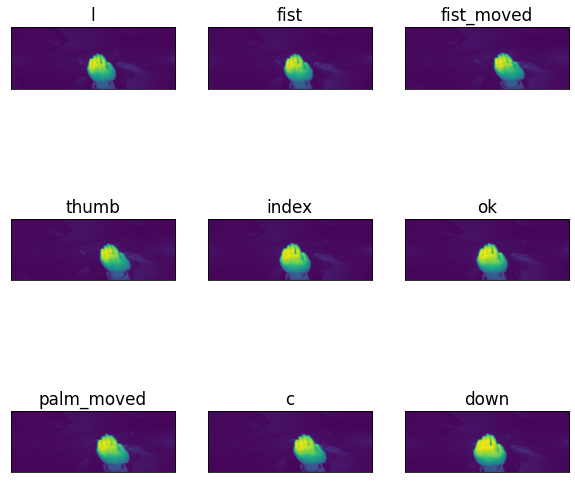

In [40]:
plt.figure(1, figsize=(10,10))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    img = Image.open(images[i])
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(CATEGORIES[i][3:])
plt.show()

# plt.figure(1, figsize=(10, 10))
# for i in range(1, 10):
#     ax = plt.subplot(3, 3, i)
#     img = Image.open(images[i])
#     plt.imshow(img)
#     plt.xticks([])
#     plt.yticks([])
#     plt.title(CATEGORIES[labels[i]][3:])
#     plt.axis('off')

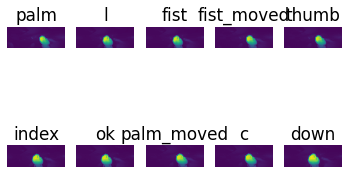

In [41]:
# plt.figure(1, figsize=(10,10))
for ind in range(10):
    ax = plt.subplot(2,5,ind+1)

    img = Image.open(images[ind])
    plt.imshow(img)
    plt.title(CATEGORIES[ind][3:])
    plt.axis('off')

In [16]:
train_dataset = SIGNSDataset(X_train, y_train, train_transformer)
test_dataset = SIGNSDataset(X_test, y_test, test_transformer)

In [17]:
batch_size = 32
lr = 0.01
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size)

### Часть 2. Создание модели

In [18]:
# Model Arch
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(79680, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [20]:
def get_model():
    model = Net()
    return model, optim.SGD(model.parameters(), lr=lr)


def loss_batch(model, loss_func, xb, yb, opt=None):
    yhat = model(xb)
    loss = loss_func(yhat, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
#     epoch_losses = []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(f'Epoch {epoch}, loss: {val_loss}')
#         epoch_losses.append(val_loss)

model, opt = get_model()
loss_func = F.cross_entropy

### Часть 3. Обучение

In [ ]:
fit(7, model, loss_func, opt, train_dl, test_dl)

0 1.1576899197896322
Epoch 0, loss: 1.1576899197896322
1 0.9772483768463135
Epoch 1, loss: 0.9772483768463135


In [20]:
losses = [np.mean(val_loss) for val_loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

NameError: name 'epoch_losses' is not defined

### Часть 4. Результаты